In [ ]:
using LinearAlgebra
using Statistics
using LsqFit
using CSV
using DataFrames
using Base.Iterators
using DataStructures
using JuMP
using Ipopt
using ForwardDiff
using OrderedCollections
using Dates
using Plots
using StatsPlots
using Distributions
using Random
using StatsBase
using LaTeXStrings 
using Optim
using Printf
using Bridge

In [ ]:
const TRUE_KAPPA = 7.0
const TRUE_THETA = 0.13
const TRUE_SIGMA = 0.02

println("Feller Condition: ", 2*TRUE_KAPPA*TRUE_THETA - TRUE_SIGMA^2 )
println(" ")
println("Variance: ", TRUE_SIGMA^2)

Feller Condition: 1.8196
 
Variance: 0.0004


In [ ]:
"""
    simulate_cir_paths(n_sim; ...)

Gera um (ou mais) caminho(s) do modelo CIR com os parâmetros verdadeiros.
"""
function simulate_cir_paths(n_sim::Int; kappa=TRUE_KAPPA, theta=TRUE_THETA, sigma=TRUE_SIGMA)
    # Simulation Parameters
    T = 1.0        # Time horizon in years
    N = 365        # Number of time steps (dias úteis)
    dt = T/N     # Time step size
    r0 = 0.129     # r0 pode ser diferente de theta

    rates = zeros(N + 1, n_sim)
    rates[1, :] .= r0
    Z = rand(Normal(0, 1), N, n_sim)

    for t in 1:N
        sqrt_r_t = @. sqrt(max(0, rates[t, :]))
        rates[t+1, :] = @. rates[t, :] + kappa * (theta - rates[t, :]) * dt +
                         sigma * sqrt_r_t * sqrt(dt) * Z[t, :]
    end
    return rates, T, N, dt, r0
end

simulate_cir_paths

In [ ]:
"""
    ols_model(initial_guess, taxas)

Calibra kappa e theta usando LsqFit (ajuste de curva).
"""
function ols_model(initial_guess::Vector{Float64}, taxas::Vector{Float64})
    r0 = taxas[1]
    t_data = (0:length(taxas)-1) ./ (length(taxas)-1) # Normaliza o tempo para ir de 0 a 1

    model_fun(t, params) = @. params[2] + (r0 - params[2])*exp(-params[1]*t) # Modified on r_0 - params -> abs
    fit = curve_fit(model_fun, t_data, taxas, initial_guess, lower=[0.0, 0.0], upper=[Inf, Inf])
    k, theta = fit.param

   return k, theta
end

ols_model

In [ ]:
"""
    estimate_sigma_squared(path, T, N, dt, r0, kappa, theta)

Estima sigma ao quadrado usando o método Z(t) com os kappa e theta já calibrados.
"""
function estimate_sigma_squared(path::Vector{Float64}, T::Float64, N::Int, dt::Float64, r0::Float64, kappa::Float64, theta::Float64)
    t_points = 0:dt:T
    num_points = N + 1
    
    # Usa os parâmetros calibrados para calcular r_bar, y, F
    r_bar = @. theta + (r0 - theta) * exp(-kappa * t_points)
    y = @. exp(kappa * t_points) * (path - r_bar)
    
    F_term_1 = @. (r0 - theta) * (exp(kappa * t_points) - 1)
    F_term_2 = @. (theta/2) * (exp(2*kappa * t_points) - 1)
    F = @. (F_term_1 + F_term_2) / kappa
    
    z_trajectory = zeros(num_points)
    
    for i in 2:num_points
        numerator = y[i]^2
        denominator = F[i] # F[1] é F(0), que é 0
        z_trajectory[i] = denominator > 1e-9 ? numerator / denominator : NaN
    end
    
    # A estimativa é a média dos Z(t) calculados ao longo do tempo
    return mean(filter(isfinite, z_trajectory))
end

estimate_sigma_squared

In [ ]:
function calibrate_cir_mle(rates::Vector{Float64}, dt::Float64)
    """
    Calibra os parâmetros do CIR (κ, θ, σ) via Máxima Verossimilhança (MLE)
    usando a distribuição exata (Qui-Quadrado Não-Central).
    """
    
    function log_likelihood(params)
        kappa, theta, sigma = params[1], params[2], params[3]
        
        if kappa <= 0 || theta <= 0 || sigma <= 0 || 2 * kappa * theta < sigma^2
             return -Inf
        end

        total_loglik = 0.0
        for i in 2:length(rates)
            r_prev = rates[i-1]
            r_curr = rates[i]
            
            c = 2 * kappa / (sigma^2 * (1 - exp(-kappa * dt)))
            dof = 4 * kappa * theta / sigma^2
            nc = 2 * c * r_prev * exp(-kappa * dt)
            
            dist = NoncentralChisq(dof, nc)
            scaled_variable = 2 * c * r_curr
            
            loglik_term = log(2c) + logpdf(dist, scaled_variable)
            
            if isinf(loglik_term) || isnan(loglik_term)
                return -Inf
            end
            total_loglik += loglik_term
        end
        return total_loglik
    end

    objective_function(params) = -log_likelihood(params)
    
    initial_guess = [0.5, 0.1, 0.1]
    lower_bounds = [1e-5, 1e-5, 1e-5]
    upper_bounds = [Inf, Inf, Inf]

    result = optimize(objective_function, lower_bounds, upper_bounds, initial_guess, Fminbox(BFGS()))
    
    if Optim.converged(result)
        return Optim.minimizer(result)
    else
        println("A otimização não convergiu.")
        return [NaN, NaN, NaN]
    end
end

mle_cir_calibration

In [ ]:
# df_calib = CSV.read("selic_over_calib.csv", DataFrame)
# taxas_calib = collect(skipmissing(df_calib.CDI))
# taxas_calib

--- Passo 1: Gerando um caminho com parâmetros conhecidos ---
Caminho gerado com sucesso.

--- Método 1: Sua Calibragem em Duas Etapas ---

--- Método 2: Máxima Verossimilhança (MLE) ---
Otimização MLE convergiu com sucesso.

--- Tabela Comparativa de Resultados ---
Parâmetro  | Valor Verdadeiro | Seu Método (Erro Rel.)    | MLE (Erro Rel.)          
--------------------------------------------------------------------------------
Kappa      | 7.0000           | 168.3798   (2305.43%    ) | 15.9554    (127.93%     )
Theta      | 0.1300           | 0.1304     (0.30%       ) | 0.1305     (0.41%       )
Sigma      | 0.0200           | 0.0650     (224.75%     ) | 0.0198     (1.22%       )


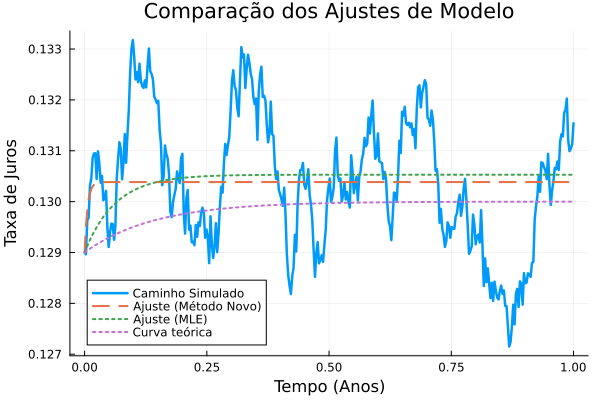

In [ ]:
# --- 4. Bloco Principal de Execução com a Comparação ---

println("--- Passo 1: Gerando um caminho com parâmetros conhecidos ---")

### SIMULATED DATA
paths, T, N, dt, r0 = simulate_cir_paths(1)
simulated_path = vec(paths)
############

### REAL DATA
# simulated_path = taxas_calib
# N = length(simulated_path) - 1
# T = 1/12
# dt = T/N
# r0 = 0.108
#############

println("Caminho gerado com sucesso.\n")
# --- ANÁLISE COM O SEU MÉTODO ---
println("--- Método 1: Sua Calibragem em Duas Etapas ---")
initial_guess_kt = [0.5, 0.1]
kappa_seu, theta_seu = ols_model(initial_guess_kt, simulated_path)
sigma_sq_seu = estimate_sigma_squared(simulated_path, T, N, dt, r0, kappa_seu, theta_seu)
sigma_seu = sqrt(sigma_sq_seu)

# --- ANÁLISE COM MÁXIMA VEROSSIMILHANÇA ---
println("\n--- Método 2: Máxima Verossimilhança (MLE) ---")
initial_guess_mle = [0.5, 0.1, 0.05]
kappa_mle, theta_mle, sigma_mle = calibrate_cir_mle(simulated_path, dt)

# --- COMPARAÇÃO FINAL (COM TABELA ALINHADA) ---
println("\n--- Tabela Comparativa de Resultados ---")
@printf "%-10s | %-16s | %-25s | %-25s\n" "Parâmetro" "Valor Verdadeiro" "Seu Método (Erro Rel.)" "MLE (Erro Rel.)"
println("-"^80)

# Kappa
err_k_seu_str = @sprintf "%.2f%%" 100*abs(kappa_seu - TRUE_KAPPA) / TRUE_KAPPA
err_k_mle_str = @sprintf "%.2f%%" 100*abs(kappa_mle - TRUE_KAPPA) / TRUE_KAPPA
@printf "%-10s | %-16.4f | %-10.4f (%-12s) | %-10.4f (%-12s)\n" "Kappa" TRUE_KAPPA kappa_seu err_k_seu_str kappa_mle err_k_mle_str

# Theta
err_t_seu_str = @sprintf "%.2f%%" 100*abs(theta_seu - TRUE_THETA) / TRUE_THETA
err_t_mle_str = @sprintf "%.2f%%" 100*abs(theta_mle - TRUE_THETA) / TRUE_THETA
@printf "%-10s | %-16.4f | %-10.4f (%-12s) | %-10.4f (%-12s)\n" "Theta" TRUE_THETA theta_seu err_t_seu_str theta_mle err_t_mle_str

# Sigma
err_s_seu_str = @sprintf "%.2f%%" 100*abs(sigma_seu - TRUE_SIGMA) / TRUE_SIGMA
err_s_mle_str = @sprintf "%.2f%%" 100*abs(sigma_mle - TRUE_SIGMA) / TRUE_SIGMA
@printf "%-10s | %-16.4f | %-10.4f (%-12s) | %-10.4f (%-12s)\n" "Sigma" TRUE_SIGMA sigma_seu err_s_seu_str sigma_mle err_s_mle_str


# --- GRÁFICO COMPARATIVO DOS AJUSTES ---
t_plot = (0:N) ./ N # Vetor de tempo de 0 a 1
p = plot(t_plot, simulated_path,
         label="Caminho Simulado",
         title="Comparação dos Ajustes de Modelo",
         xlabel="Tempo (Anos)",
         ylabel="Taxa de Juros",
         linewidth=2.5,
         legend=:best)

# Curva do modelo com os parâmetros do seu método
plot!(p, t_plot, t -> theta_seu + (r0 - theta_seu)*exp(-kappa_seu*t),
      label="Ajuste (Método Novo)",
      linestyle=:dash,
      linewidth=2)

# Curva do modelo com os parâmetros do MLE
plot!(p, t_plot, t -> theta_mle + (r0 - theta_mle)*exp(-kappa_mle*t),
      label="Ajuste (MLE)",
      linestyle=:dot,
      linewidth=2)

# Curva téorica
plot!(p, t_plot, t -> TRUE_THETA + (r0 - TRUE_THETA)*exp(-TRUE_KAPPA*t),
      label="Curva teórica",
      linestyle=:dot,
      linewidth=2)

display(p)